[source: towardsdatascience](https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651)<br />
### Time Series Prediction with LSTMs
Let's start with a simple example of forecasting the values of the `Sine function` using a simple LSTM network.
#### Check the version

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc0


### Setup
Start with the library imports and setting seeds;

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'# 그래프를 더 높은 해상도로 출력한다.

sns.set(style = 'whitegrid', palette = 'muted',font_scale=1.5) # 배경 흰 색으로 하고 팔레트 선택(아래 참고)

rcParams['figure.figsize'] = 16,10 # 출력할 사진 크기 설정

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

![image](https://user-images.githubusercontent.com/46597294/72580545-d2b3f580-391f-11ea-80cc-334d64c68608.png)
### Data
Generate 1000 values from the sine function and use that as training data. But, let's add a little bit of noise to it;

In [7]:
time = np.arange(0,100,0.1)
print('time[:10] : \n',time[:10])
print('type(time) : ',type(time))
sin = np.sin(time) + np.random.normal(scale = 0.5, size = len(time)) # 정규분포 따르는 난수 생성, 이때 std를 0.5로 설정함
print('sin[:10] : \n',sin[:10])

time[:10] : 
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
type(time) :  <class 'numpy.ndarray'>
sin[:10] : 
 [-0.95390378 -0.33035909 -0.00813344  1.23936404  0.6676949  -0.18831525
  0.80766062 -0.12943431  1.25870162  0.54776458]


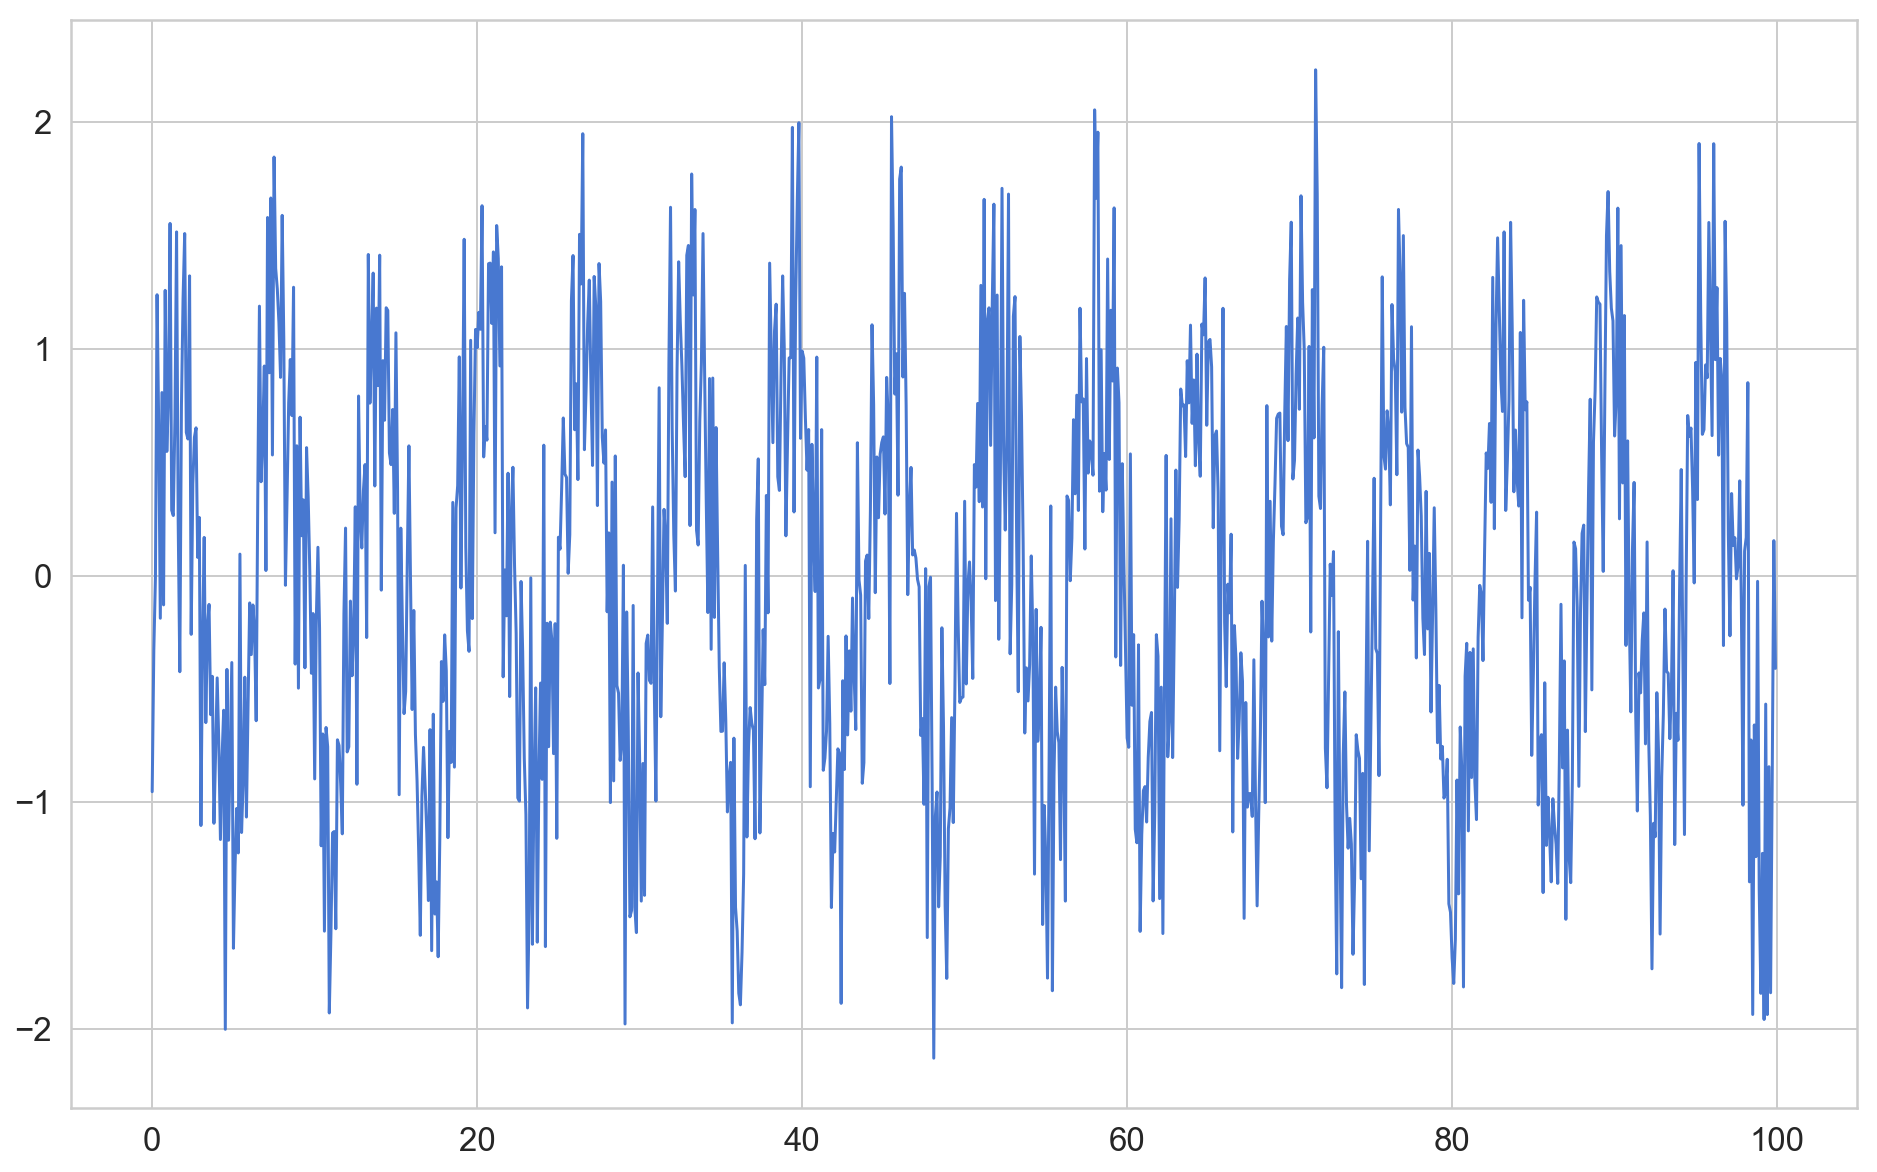

In [13]:
plt.plot(time,sin)

### Data Preprocessing
We need to 'chop the data' into smaller sequences for our model. First, we'll split it into training and test data;

In [14]:
dict(sine=sin)

{'sine': array([-0.95390378, -0.33035909, -0.00813344,  1.23936404,  0.6676949 ,
        -0.18831525,  0.80766062, -0.12943431,  1.25870162,  0.54776458,
         0.79465289,  1.55410568,  0.2884573 ,  0.26499909,  0.69365007,
         1.51668441,  0.23990057, -0.42441299,  0.7482682 ,  1.22217049,
         1.5094283 ,  0.63162869,  0.6027831 ,  1.32265558, -0.25940767,
         0.40421176,  0.61071332,  0.65198924,  0.0800848 ,  0.25646984,
        -1.10304367, -0.28754354,  0.16838021, -0.64889271, -0.22604899,
        -0.12734698, -0.61379504, -0.44460426, -1.09322417, -0.7910718 ,
        -0.45169441, -0.73979063, -1.16484141, -0.80405773, -0.59429718,
        -2.00250076, -0.41415397, -1.16805063, -0.78341964, -0.38382915,
        -1.64476112, -1.28053518, -1.027729  , -1.2241442 ,  0.0947038 ,
        -1.13392637, -0.90904003, -0.44849103, -1.06567694, -0.57171702,
        -0.12068887, -0.34859271, -0.12978283, -0.24785216, -0.64068595,
         0.37591659,  1.1890079 ,  0.414050

In [15]:
df = pd.DataFrame(dict(sine=sin), index = time, columns = ['sine'])
df.head()

,sine
0.0,-0.953904
0.1,-0.330359
0.2,-0.008133
0.3,1.239364
0.4,0.667695


In [18]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train),len(test))

800 200


In [57]:
test.head()
# print(test.index)
# print(test.sine)

,sine
80.0,-1.688160
80.1,-1.800079
80.2,-1.604649
80.3,-0.902389
80.4,-1.404813


Preparing the data for Time Series forecasting(LSTMs in particular) can be tricky. Intuitively, we need to predict the value at the current time step by using the history(n time steps from it). Here's a generic function that does the job;

In [20]:
def create_dataset(X,y,time_steps = 1):
    Xs,ys = [],[]
    for i in range(len(X)-time_steps):
        v = X.iloc[i:(i+time_steps)].values # DataFrame에서 값만 받아오려고 values function 이용.
        Xs.append(v) # time_steps = 1이라면 X의 i 번째 value값만 들어가고, time_steps >1 이면 X의 i 번째부터 i+time_steps-1번째 값까지 들어가게 됨.
        ys.append(y.iloc[i+time_steps]) # 여기엔 y의 (i+1)번째 value 값이 들어가게 되는 게지
    return np.array(Xs), np.array(ys)

The beauty of this function is that it works with univariate (single feature) and multivariate (multiple features) Time Series data. Let's use a history of 10 time steps to make our sequences;

In [21]:
time_steps = 10

# reshape to [samples, time_steps, n_features] --> always?

X_train, y_train = create_dataset(train, train.sine, time_steps)
X_test, y_test = create_dataset(test, test.sine, time_steps)

print(X_train.shape, y_train.shape)

(790, 10, 1) (790,)


여기서 X_train, y_train, X_test, y_test가 정확히 어떻게 생겼는지 이해하고 넘어가야함. Training에서는 X_train에서 10개 time_step을 이용해서 11번째 sine값(y_train)을 예측하는 걸 학습시키고 이후 pred 및 evaluation할 때, X_test값을 이용해서 y_pred를 출력하고 y_test과 비교

In [53]:
X_train

array([[[-0.95390378],
        [-0.33035909],
        [-0.00813344],
        ...,
        [-0.12943431],
        [ 1.25870162],
        [ 0.54776458]],

       [[-0.33035909],
        [-0.00813344],
        [ 1.23936404],
        ...,
        [ 1.25870162],
        [ 0.54776458],
        [ 0.79465289]],

       [[-0.00813344],
        [ 1.23936404],
        [ 0.6676949 ],
        ...,
        [ 0.54776458],
        [ 0.79465289],
        [ 1.55410568]],

       ...,

       [[-0.60212386],
        [-0.16672666],
        [ 0.2991929 ],
        ...,
        [-0.75402228],
        [-0.98210241],
        [-0.95461286]],

       [[-0.16672666],
        [ 0.2991929 ],
        [-0.15102977],
        ...,
        [-0.98210241],
        [-0.95461286],
        [-0.81082976]],

       [[ 0.2991929 ],
        [-0.15102977],
        [-0.73754871],
        ...,
        [-0.95461286],
        [-0.81082976],
        [-1.44882584]]])

In [52]:
y_train

array([ 0.79465289,  1.55410568,  0.2884573 ,  0.26499909,  0.69365007,
        1.51668441,  0.23990057, -0.42441299,  0.7482682 ,  1.22217049,
        1.5094283 ,  0.63162869,  0.6027831 ,  1.32265558, -0.25940767,
        0.40421176,  0.61071332,  0.65198924,  0.0800848 ,  0.25646984,
       -1.10304367, -0.28754354,  0.16838021, -0.64889271, -0.22604899,
       -0.12734698, -0.61379504, -0.44460426, -1.09322417, -0.7910718 ,
       -0.45169441, -0.73979063, -1.16484141, -0.80405773, -0.59429718,
       -2.00250076, -0.41415397, -1.16805063, -0.78341964, -0.38382915,
       -1.64476112, -1.28053518, -1.027729  , -1.2241442 ,  0.0947038 ,
       -1.13392637, -0.90904003, -0.44849103, -1.06567694, -0.57171702,
       -0.12068887, -0.34859271, -0.12978283, -0.24785216, -0.64068595,
        0.37591659,  1.1890079 ,  0.41405074,  0.60674541,  0.92480114,
        0.02232135,  1.58022637,  0.89483226,  1.66636507,  0.5321916 ,
        1.84703094,  1.35549742,  1.26468828,  1.11555557,  0.87

We have our sequences in the shape (samples, time_steps, features). How can we use them to make predictions?
### Modeling
Training an LSTM model in Keras is easy. We'll use the <u>LSTM layer</u> in a sequential model to make our predictions:<br /><br />
<br /> `Sequential`모델은 레이어를 선형으로 연결하여 구성한다. 레이어 인스턴스를 생성자에게 넘겨줌으로써 `Sequential`모델을 구성할 수 있다. 또한, `.add()`메소드를 통해 쉽게 레이어를 추가할 수 있다.[Keras Documentation](https://keras.io/ko/getting-started/sequential-model-guide/) 

In [22]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=128, # layer with 128 units
    input_shape=(X_train.shape[1],X_train.shape[2]) # input_shape 에 batch dimension은 포함 안된다.
))
model.add(keras.layers.Dense(units=1))
model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(0.001)
)

**The LSTM layer expects the number of time steps and the number of features to work properly.** The rest of the model looks like a regular regression model. How do we train an LSTM model?
### Training
The most important thing to remember when training Time Series models is to **not shuffle the data (the order of the data matters).** The rest is pretty standard;

Train on 711 samples, validate on 79 samples
Epoch 1/30
711/711 [==============================] - 0s 360us/sample - loss: 0.2757 - val_loss: 0.3172
Epoch 2/30
711/711 [==============================] - 0s 320us/sample - loss: 0.2708 - val_loss: 0.3114
Epoch 3/30
711/711 [==============================] - 0s 316us/sample - loss: 0.2665 - val_loss: 0.3286
Epoch 4/30
711/711 [==============================] - 0s 334us/sample - loss: 0.2706 - val_loss: 0.3354
Epoch 5/30
711/711 [==============================] - 0s 324us/sample - loss: 0.2678 - val_loss: 0.3327
Epoch 6/30
711/711 [==============================] - 0s 334us/sample - loss: 0.2608 - val_loss: 0.3444
Epoch 7/30
711/711 [==============================] - 0s 360us/sample - loss: 0.2569 - val_loss: 0.3515
Epoch 8/30
711/711 [==============================] - 0s 327us/sample - loss: 0.2529 - val_loss: 0.3660
Epoch 9/30
711/711 [==============================] - 0s 346us/sample - loss: 0.2485 - val_loss: 0.3799
Epoch 10/30
711/711

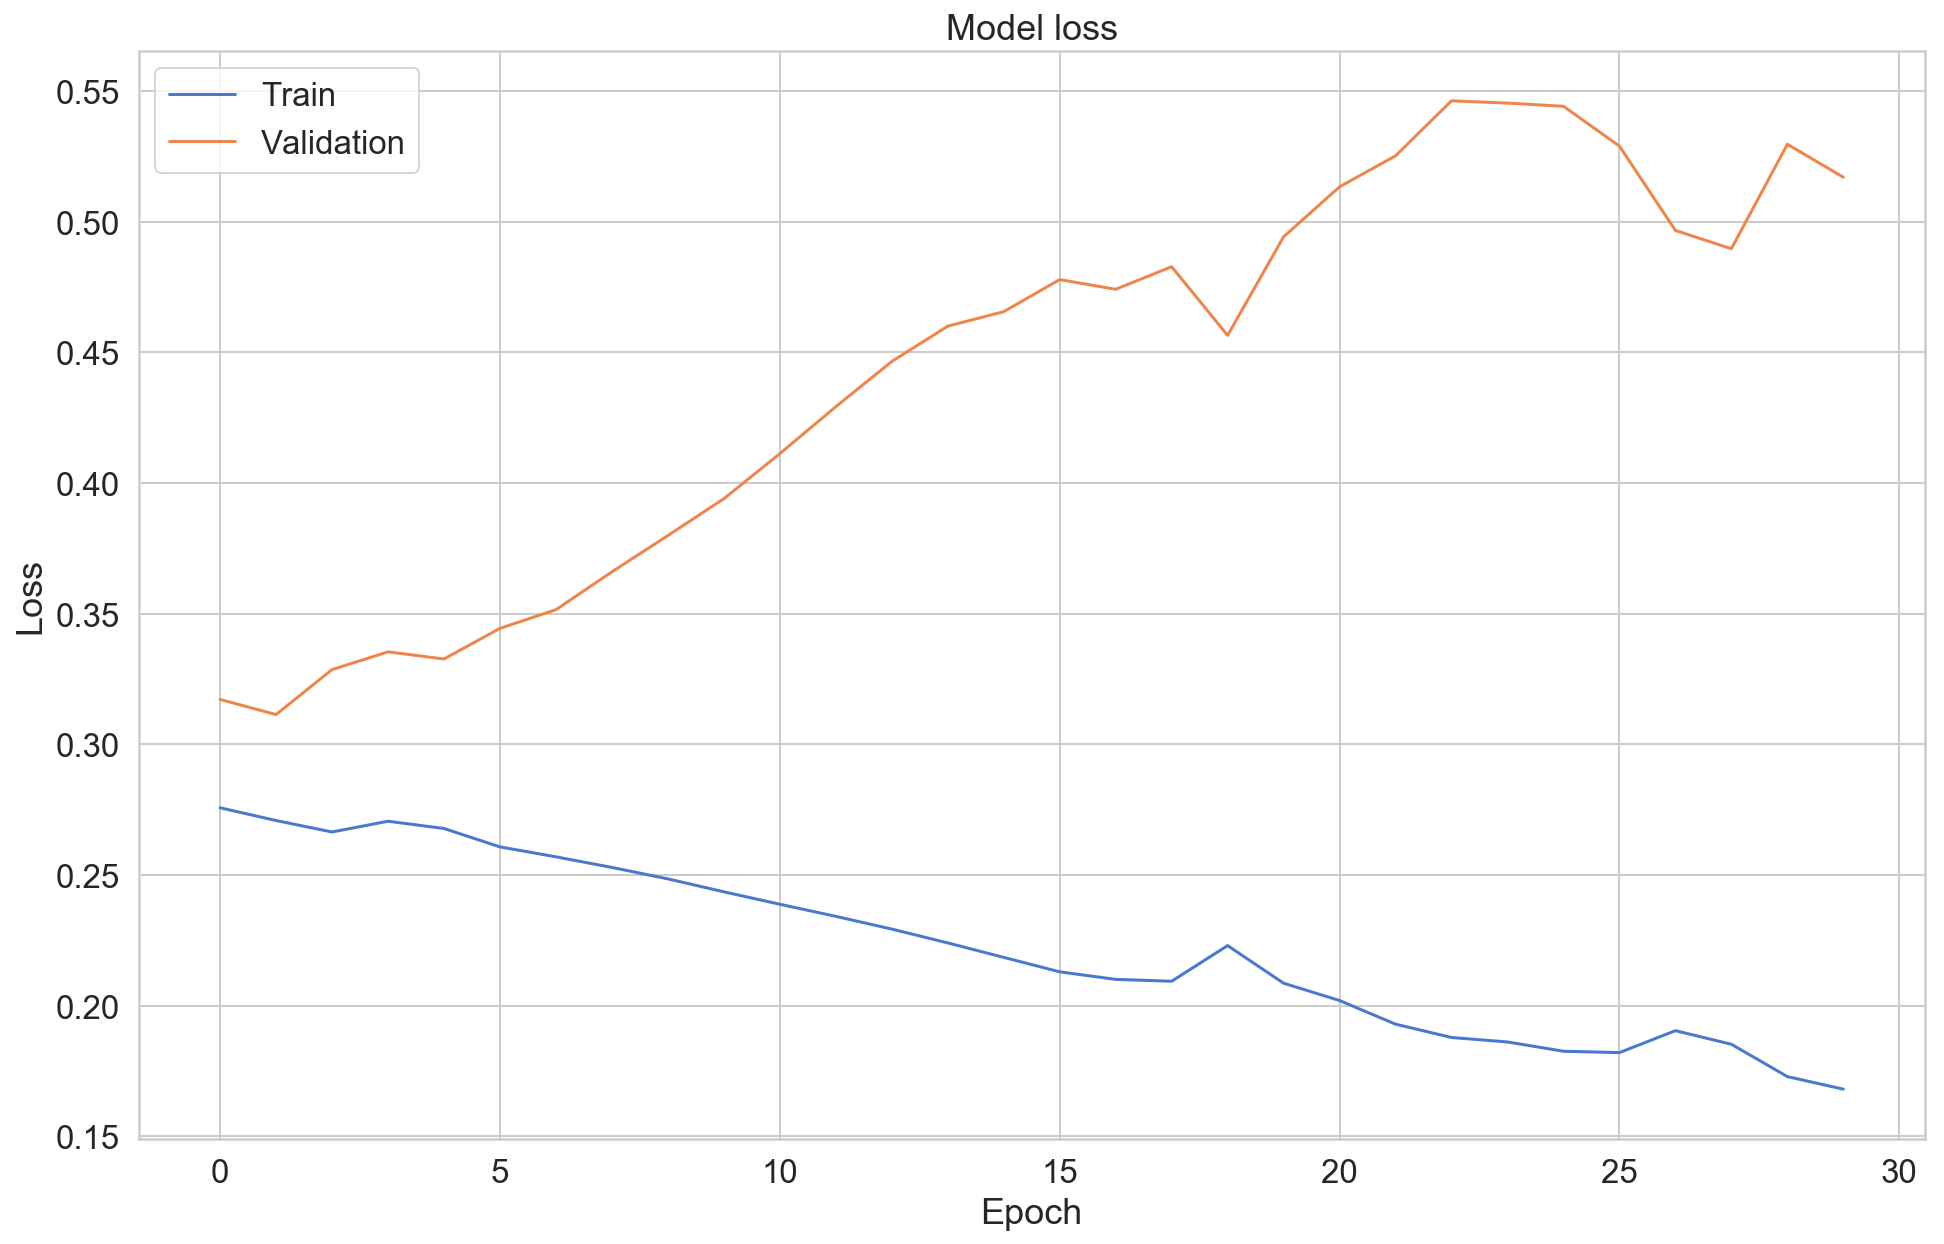

In [27]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

# 학습 손실 값과 검증 손실 값을 플롯팅 합니다.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

####  (참고) What is the use of verbose while training the model?
* verbose = 0 will show you nth (silent)
* verbose = 1 will show you an animated progress bar like this: [===========]
* verbose = 2 will just mention the number of epoch like this: **Epoch 1/10**

<br />
(The dataset is pretty simple though and i just copy the code from the 'source', idk why the model can't be fitted on the data. Why LSTM is not working here? But I'll just proceed)

### Evaluation
Let's take some predictions from our model:

In [28]:
y_pred = model.predict(X_test)
print(y_pred)

[[-0.59870887]
 [-0.51528263]
 [-0.5636095 ]
 [-0.48875633]
 [-0.5356996 ]
 [-0.4271282 ]
 [-0.18922889]
 [ 0.08783613]
 [-0.9150163 ]
 [-0.04694971]
 [ 0.0128964 ]
 [ 0.12736943]
 [ 0.37463078]
 [ 0.25769165]
 [ 0.97130716]
 [ 0.63247406]
 [ 0.32019085]
 [ 1.3153559 ]
 [ 0.6055002 ]
 [ 0.86290467]
 [ 0.65991366]
 [ 0.6583884 ]
 [ 0.6570538 ]
 [ 0.7250241 ]
 [ 0.9421673 ]
 [ 0.51708984]
 [ 0.6063473 ]
 [ 0.39562616]
 [ 0.614169  ]
 [ 0.4880676 ]
 [ 0.7696978 ]
 [ 0.9322947 ]
 [ 0.682709  ]
 [ 0.29397526]
 [ 0.7898406 ]
 [ 0.6975672 ]
 [ 1.4027246 ]
 [ 1.0516398 ]
 [ 0.7955266 ]
 [ 0.47125658]
 [-0.04799098]
 [-0.3277645 ]
 [-0.10362796]
 [-0.23355842]
 [-0.56400704]
 [-0.3875038 ]
 [-1.2456157 ]
 [-0.811607  ]
 [-1.3015476 ]
 [-1.8101584 ]
 [-1.4150779 ]
 [-1.3392032 ]
 [-0.6516243 ]
 [-0.8482119 ]
 [-1.0041771 ]
 [-0.7900028 ]
 [-0.48084947]
 [-0.799459  ]
 [-0.58847404]
 [-0.5857024 ]
 [-0.6397821 ]
 [-0.44437474]
 [-0.5947398 ]
 [-0.29474664]
 [-0.15464182]
 [-0.27096027]
 [-1.22325

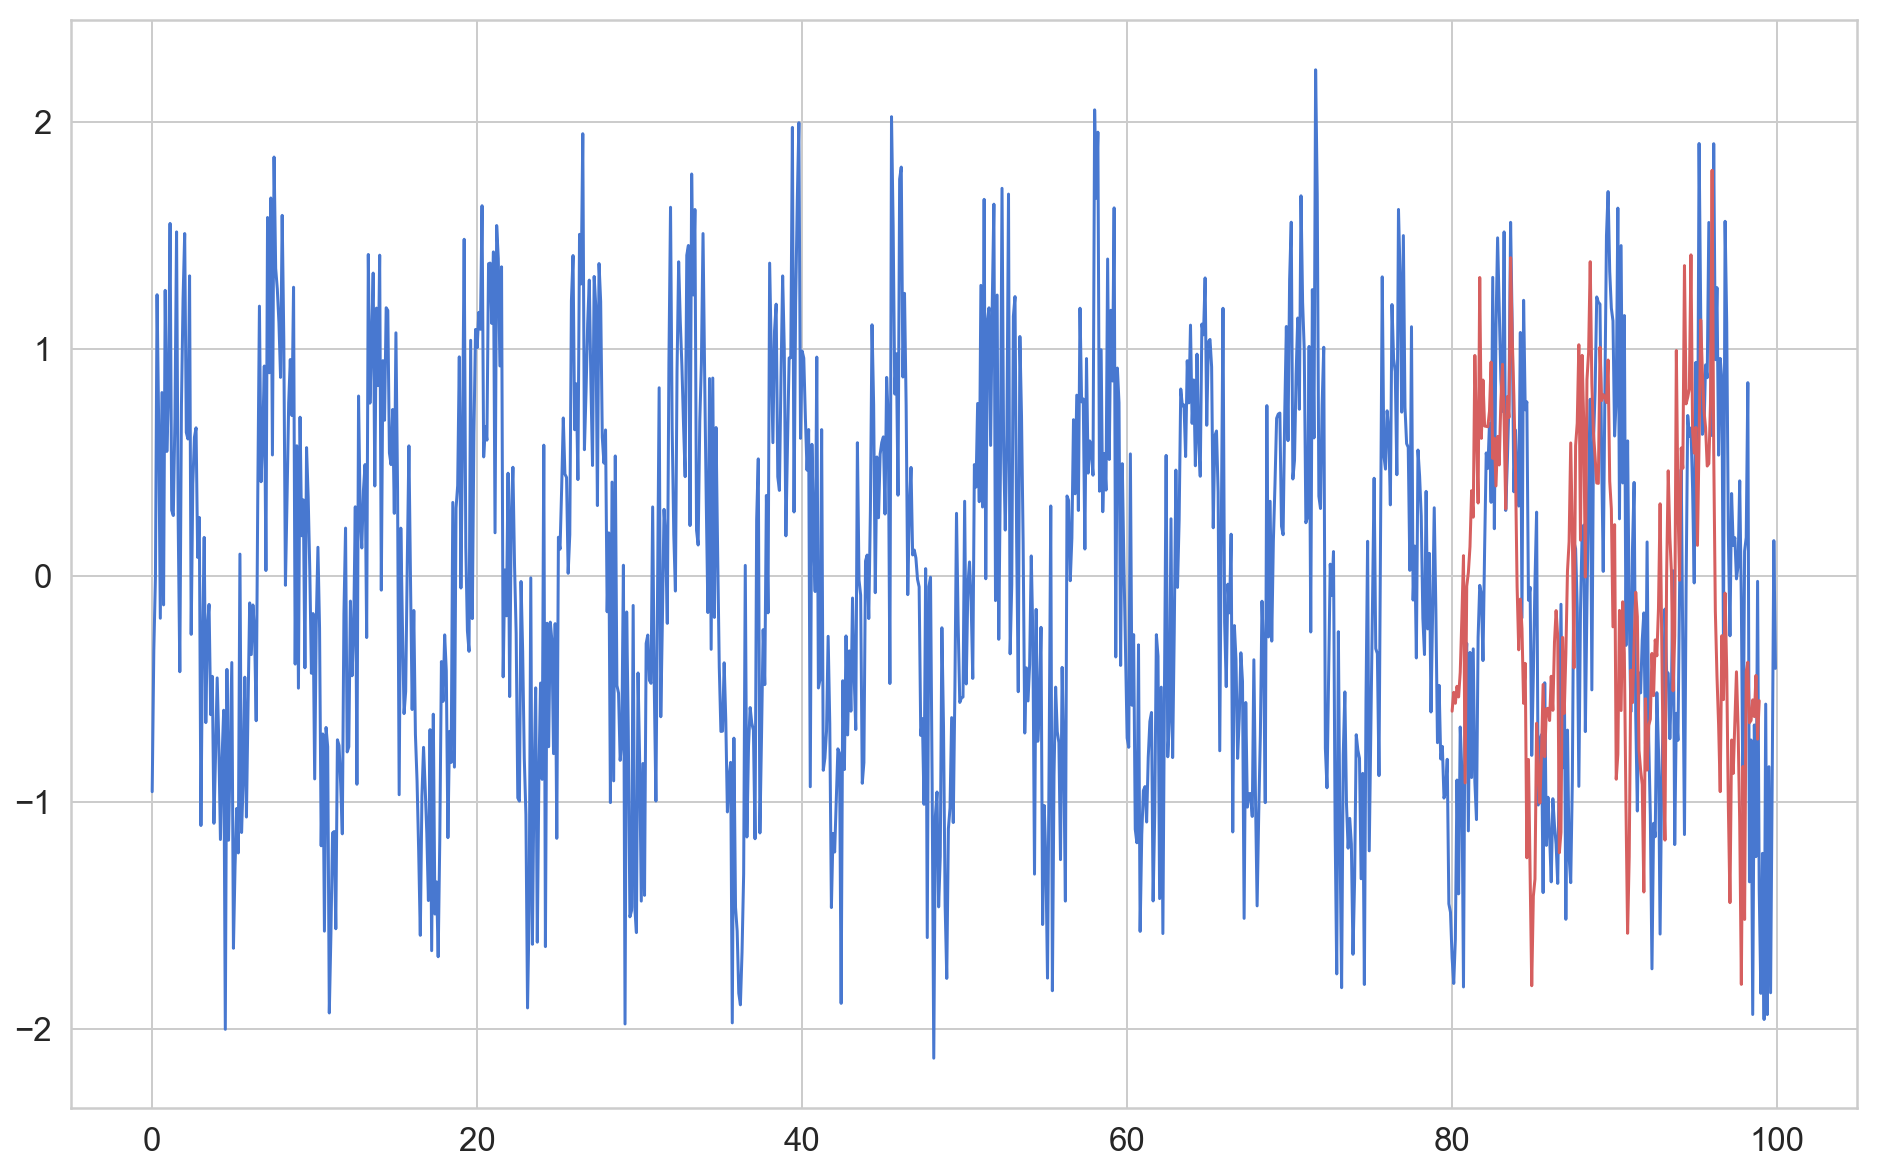

In [63]:
plt.plot(time,sin,'b') # original data
plt.plot(test.index[0:190],y_pred.flatten(),'r')
plt.show()

In [61]:
print(len(y_pred.flatten()))
print(len(test.index))

190
200


Predictions look fine on this scale. Let's zoom in:

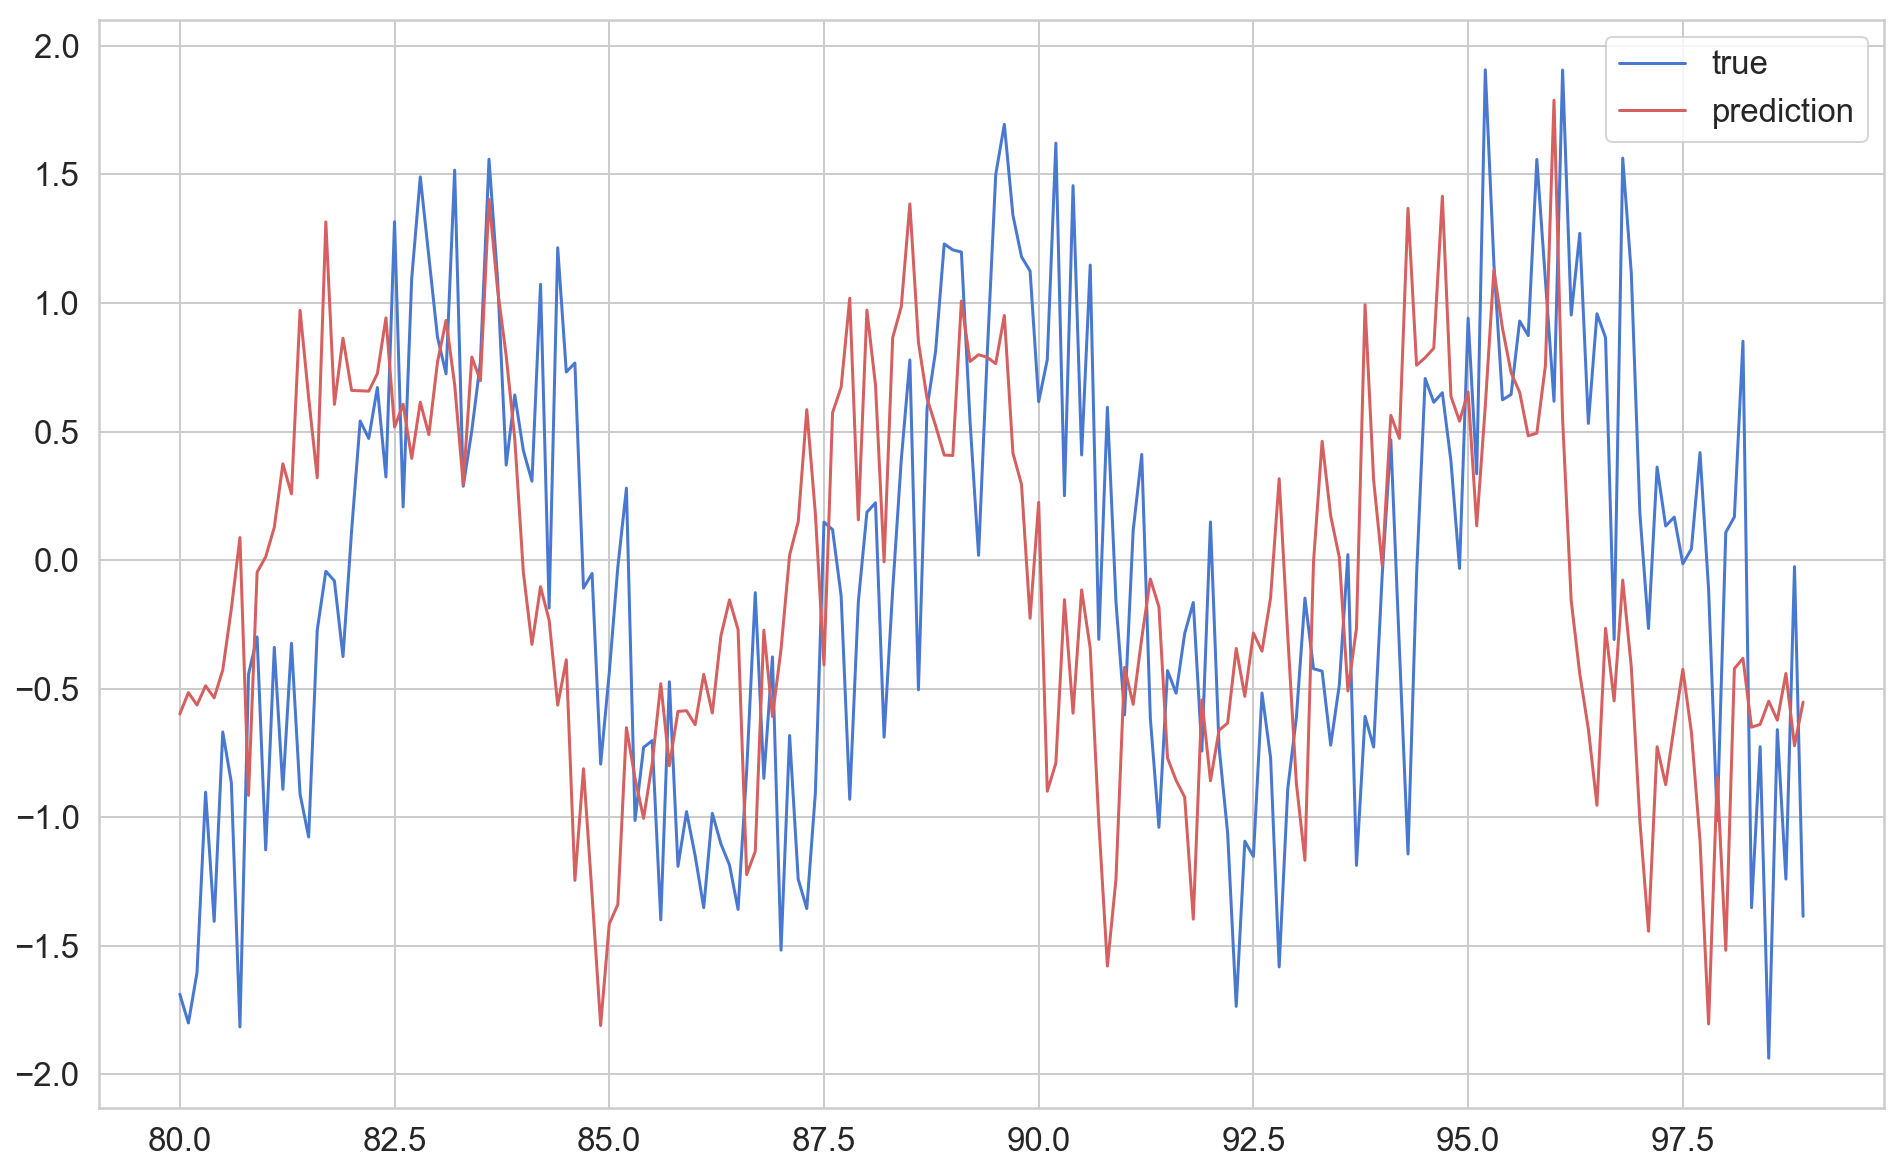

In [75]:
plt.plot(test.index[0:190],test.sine.values[0:190],'b',label='true') # shape 잘 맞춰줄 것!
plt.plot(test.index[0:190],y_pred.flatten(),'r',label='prediction')
plt.legend()
plt.show()

The model seems to be doing a good job of capturing the general pattern of the data. It fails to capture random fluctuations, which is a good thing (it generalizes well).
### Conclusion
Congratulations to myself on making my first RNN model! lol:) Next Posting will be about how to use Multivariate Time Series data.